# Earnings Call Sentiment Analysis

## Project Overview

We analyze earnings call transcripts using 3 different approaches:

**Dictionary Method (Based on Loughran-McDonald dictionary):**
- Counts positive and negative words from a financial dictionary
- Simple word counting: "strong" = +1, "risk" = -1
- Fast, transparent, and reproducible
- Limitation: Cannot understand context or negation

**Pre-Trained Language Model (FinBERT AI Transformer Model):**
- Analyzes complete sentences and paragraphs, not individual words
- Trained specifically on 4,000+ financial documents
- Better job at understanding context, tone, and relationships between words
- Can detect nuance: "not bad" is positive, "despite challenges" can be positive
- Limitation: Less transparent, may still lack some accuracy with complex sentences

**Gen AI Model:**

## Step 1: Import Required Libraries

In [1]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for downloading and handling files
import requests
from pathlib import Path

# Import library for PDF text extraction
from pypdf import PdfReader

# Import libraries for text processing
import re
from collections import Counter

# Import libraries for FinBERT transformer model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Set visualization style preferences
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Step 2: Download Earnings Call Transcript

In [2]:
# Define the URL where the earnings call transcript PDF is hosted
transcript_url = "https://www.td.com/content/dam/tdcom/canada/about-td/pdf/quarterly-results/2025/q4/2025-q4-td-transcript.pdf"

# Define the local file path where we will save the downloaded PDF
pdf_file_path = Path("td_q4_2025_transcript.pdf")

# Send an HTTP GET request to download the PDF file from the URL
http_response = requests.get(transcript_url, timeout=60) #requests is from the requests library
http_response.raise_for_status() #will show us the error if any
pdf_file_path.write_bytes(http_response.content) #will store the data to the file specified with the name specified in pdf_file_path

print(f"Downloaded: {pdf_file_path}")
print(f"File size: {pdf_file_path.stat().st_size / 1024:.1f} KB")

Downloaded: td_q4_2025_transcript.pdf
File size: 283.1 KB


## Step 3: Extract Text from PDF

In [26]:
# Create a PDF reader object to access the downloaded transcript
pdf_reader = PdfReader(pdf_file_path)

# Initialize an empty list to store data from each page
pages_data = []

# Loop through each page in the PDF document
for page_number, page_object in enumerate(pdf_reader.pages, start=1):
    page_text = page_object.extract_text()
    pages_data.append({
        'page_number': page_number,
        'raw_text': page_text
    })

# Convert the list of dictionaries into a pandas DataFrame for better analysis
transcript_data = pd.DataFrame(pages_data)

print(f"Extracted {len(transcript_data)} pages")
print(f"Total characters: {transcript_data['raw_text'].str.len().sum():,}")

Extracted 17 pages
Total characters: 70,678


## Step 4: Find Start of Substantive Content and Remove irrelevant info
We remove:
- Page headers and footers ("Page X of Y")
- Section headers ("Canadian Personal Bank")
- Speaker name headers ("John Smith - Analyst")
- Transcript metadata

In [30]:
# Define a function to find where substantive content begins
def find_presentation_start(dataframe):
    for idx, row in dataframe.iterrows():
        text_no_spaces = row['raw_text'].upper().replace(' ', '')
        if 'PRESENTATION' in text_no_spaces or 'MANAGEMENTDISCUSSION' in text_no_spaces:
            if 'PRESENTATION' in text_no_spaces[:500] or 'MANAGEMENTDISCUSSION' in text_no_spaces[:500]:
                if row['page_number'] > 1:
                    return row['page_number']
    return 1

# Define a function to remove boilerplate text from each page
def remove_boilerplate_text(text):
    lines = text.split('\n')
    cleaned_lines = []
    
    for line in lines:
        line_stripped = line.strip()
        
        # Skip empty lines
        if not line_stripped:
            continue
        
        # Skip page numbers (e.g., "Page 14 of 17")
        if re.search(r'Page\s+\d+\s+of\s+\d+', line_stripped, re.IGNORECASE):
            continue
        
        # Skip lines containing "Earnings Call Transcript"
        if 'Earnings Call Transcript' in line_stripped:
            continue
        
        # Skip lines that are just dates (e.g., "December 4, 2025")
        if re.search(r'^[A-Za-z]+\s+\d+,\s+\d{4}$', line_stripped):
            continue
        
        # Skip section headers that are alone on a line and all caps or title case
        # (e.g., "Canadian Personal Bank", "CORPORATE SEGMENT")
        if len(line_stripped) < 60 and line_stripped.isupper():
            # Check if it looks like a section header (short, all caps, no sentence structure)
            if not any(word in line_stripped.lower() for word in ['the', 'and', 'our', 'we', 'are', 'is']):
                continue
        
        # Skip speaker/analyst headers (e.g., "John Smith - Company Name - Title")
        # These typically have format: Name - Company - Title with dashes
        if line_stripped.count(' - ') >= 2 or line_stripped.count('–') >= 2:
            # Check if it's a short line that's likely a header, not a sentence
            if len(line_stripped) < 100 and not line_stripped.endswith('.'):
                continue
        
        # Keep this line
        cleaned_lines.append(line_stripped)
    
    # Rejoin cleaned lines
    return ' '.join(cleaned_lines)

# Find the page number where substantive content begins
start_page = find_presentation_start(transcript_data)

# Filter to include only substantive content pages
substantive_content = transcript_data[transcript_data['page_number'] >= start_page].copy()

# Remove boilerplate from each page
substantive_content['raw_text'] = substantive_content['raw_text'].apply(remove_boilerplate_text)

print(f"Analysis starts from page {start_page}")
print(f"Pages excluded (boilerplate): {start_page - 1}")
print(f"Pages for analysis: {len(substantive_content)}")
print(f"\nCleaning performed:")
print(f"Removed page headers and footers")
print(f"Removed section headers")
print(f"Removed speaker name headers")
print(f"Removed transcript metadata")

Analysis starts from page 3
Pages excluded (boilerplate): 2
Pages for analysis: 15

Cleaning performed:
Removed page headers and footers
Removed section headers
Removed speaker name headers
Removed transcript metadata


## Step 5: Clean and Normalize Text

In [31]:
# Define a function to clean and normalize financial text
def clean_financial_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = ' '.join(text.split())
    return text

# Apply cleaning function to each page's text
substantive_content['cleaned_text'] = substantive_content['raw_text'].apply(clean_financial_text)
substantive_content['word_count'] = substantive_content['cleaned_text'].str.split().str.len()

print(f"Total words in substantive content: {substantive_content['word_count'].sum():,}")

Total words in substantive content: 9,280


## Step 6: Remove Stopwords

In [32]:
# Read stopwords file
stopwords_file_path = Path("stopwords.txt")
with open(stopwords_file_path, 'r') as file:
    stopwords_set = set(word.strip().lower() for word in file.readlines())

# Define function to remove stopwords
def remove_stopwords(text, stopword_set):
    words = text.split()
    filtered_words = [word for word in words if word not in stopword_set]
    return ' '.join(filtered_words)

# Apply stopword removal
substantive_content['cleaned_text'] = substantive_content['cleaned_text'].apply(
    lambda text: remove_stopwords(text, stopwords_set)
)
substantive_content['word_count'] = substantive_content['cleaned_text'].str.split().str.len()

print(f"Total words after removing stopwords: {substantive_content['word_count'].sum():,}")

Total words after removing stopwords: 5,435


# Method 1: Dictionary-Based Sentiment Analysis

## How Dictionary Method Works:

1. We load financial dictionary with pre-classified words ("Loughran-McDonald Financial Dictionary.csv")
2. Count positive words: "gain" (+1), "strong" (+1), "profit" (+1)
3. Count negative words: "loss" (-1), "risk" (-1), "decline" (-1)
4. Calculate net sentiment: (Positive - Negative) / Total Words × 100

Example:If a page has 100 words with 5 positive and 3 negative:
- Net sentiment = (5 - 3) / 100 × 100 = +2.0%

## Step 7: Load Loughran-McDonald Financial Dictionary

In [33]:
# Load the Loughran-McDonald dictionary
dictionary_file_path = "Loughran-McDonald_MasterDictionary_1993-2024.csv"
loughran_mcdonald_dictionary = pd.read_csv(dictionary_file_path)
loughran_mcdonald_dictionary['word_lower'] = loughran_mcdonald_dictionary['Word'].str.lower()

# Extract positive and negative word sets
positive_words_set = set(
    loughran_mcdonald_dictionary[loughran_mcdonald_dictionary['Positive'] != 0]['word_lower'].tolist()
)
negative_words_set = set(
    loughran_mcdonald_dictionary[loughran_mcdonald_dictionary['Negative'] != 0]['word_lower'].tolist()
)

print(f"Positive words in dictionary: {len(positive_words_set):,}")
print(f"Negative words in dictionary: {len(negative_words_set):,}")

Positive words in dictionary: 354
Negative words in dictionary: 2,355


## Step 8: Calculate Dictionary-Based Sentiment Scores

In [35]:
# Define function to calculate sentiment metrics
def calculate_page_sentiment(text, positive_set, negative_set):
    words = text.split()
    positive_count = sum(1 for word in words if word in positive_set)
    negative_count = sum(1 for word in words if word in negative_set)
    net_sentiment = positive_count - negative_count
    return positive_count, negative_count, net_sentiment

# Apply sentiment calculation to each page
sentiment_results = substantive_content['cleaned_text'].apply(
    lambda text: calculate_page_sentiment(text, positive_words_set, negative_words_set)
)

substantive_content['positive_count'] = sentiment_results.apply(lambda x: x[0])
substantive_content['negative_count'] = sentiment_results.apply(lambda x: x[1])
substantive_content['net_sentiment'] = sentiment_results.apply(lambda x: x[2])
substantive_content['sentiment_ratio'] = (
    (substantive_content['net_sentiment'] / substantive_content['word_count']) * 100
).fillna(0)

# Calculate overall statistics
total_words = substantive_content['word_count'].sum()
total_positive = substantive_content['positive_count'].sum()
total_negative = substantive_content['negative_count'].sum()
overall_net_sentiment = total_positive - total_negative
overall_sentiment_ratio = (overall_net_sentiment / total_words) * 100

print(f"\nTotal Words Analyzed: {total_words:,}")
print(f"Positive Words Found: {total_positive:,} ({total_positive/total_words*100:.2f}%)")
print(f"Negative Words Found: {total_negative:,} ({total_negative/total_words*100:.2f}%)")
print(f"Net Sentiment: {overall_net_sentiment:+,}")
print(f"Sentiment Ratio: {overall_sentiment_ratio:+.2f}%")
print(f"\nInterpretation: For every 100 words, there are {overall_sentiment_ratio:+.2f} more positive than negative words")


Total Words Analyzed: 5,435
Positive Words Found: 194 (3.57%)
Negative Words Found: 105 (1.93%)
Net Sentiment: +89
Sentiment Ratio: +1.64%

Interpretation: For every 100 words, there are +1.64 more positive than negative words


## Step 9&10: Dictionary Method - Extract sentences and identify Top 20 Positive Words with Context

In [37]:
# Define function to find example sentences containing a specific word
def find_example_sentences(word, text, num_examples=1):
    sentences = text.split('.')
    matching_sentences = []
    
    for sentence in sentences:
        sentence_lower = sentence.lower().strip()
        if f' {word} ' in f' {sentence_lower} ':
            cleaned_sentence = sentence.strip()
            if len(cleaned_sentence) > 20:
                matching_sentences.append(cleaned_sentence)
                if len(matching_sentences) >= num_examples:
                    break
    
    if matching_sentences:
        return matching_sentences[0][:200] + "..." if len(matching_sentences[0]) > 200 else matching_sentences[0]
    else:
        return "No clear example found"

# Combine all text for sentence extraction
full_raw_transcript = ' '.join(substantive_content['raw_text'].tolist())
full_cleaned_transcript = ' '.join(substantive_content['cleaned_text'].tolist())
all_cleaned_words = full_cleaned_transcript.split()

In [38]:
# Extract positive words found in transcript
positive_words_found = [word for word in all_cleaned_words if word in positive_words_set]
positive_word_frequencies = Counter(positive_words_found)
top_20_positive_words = positive_word_frequencies.most_common(20)

# Create detailed list with examples
top_positive_with_context = []
for word, frequency in top_20_positive_words:
    example_sentence = find_example_sentences(word, full_raw_transcript, num_examples=1)
    top_positive_with_context.append({
        'Word': word,
        'Frequency': frequency,
        'Example Context': example_sentence
    })

top_positive_df = pd.DataFrame(top_positive_with_context)

print("DICTIONARY METHOD: TOP 20 POSITIVE WORDS")
print()
for idx, row in top_positive_df.head(10).iterrows():
    print(f"{idx+1}. {row['Word'].upper()} (used {row['Frequency']} times)")
    print(f"   Example: {row['Example Context']}")
    print()

DICTIONARY METHOD: TOP 20 POSITIVE WORDS

1. STRONG (used 36 times)
   Example: We ended the year with another strong quarter, which I'm looking forward to discussing in a minute, along with the progress we've made against our new strategic pillars

2. GOOD (used 19 times)
   Example: Good morning and welcome to TD Bank Group’s fourth  quarter 2025 results presentation

3. POSITIVE (used 16 times)
   Example: Our year-over-year expense growth moderated this quarter and we delivered positive operating leverage

4. STABLE (used 12 times)
   Example: PCLs were stable quarter -over-quarter, reflecting strong credit performance

5. PROGRESS (used 10 times)
   Example: We ended the year with another strong quarter, which I'm looking forward to discussing in a minute, along with the progress we've made against our new strategic pillars

6. STRENGTH (used 9 times)
   Example: Corporate Access rankings, which demonstrates the strength of our relationships across corporate and institutional clie

## Step 11: Dictionary Method - Top 20 Negative Words with Context

In [39]:
# Extract negative words found in transcript
negative_words_found = [word for word in all_cleaned_words if word in negative_words_set]
negative_word_frequencies = Counter(negative_words_found)
top_20_negative_words = negative_word_frequencies.most_common(20)

# Create detailed list with examples
top_negative_with_context = []
for word, frequency in top_20_negative_words:
    example_sentence = find_example_sentences(word, full_raw_transcript, num_examples=1)
    top_negative_with_context.append({
        'Word': word,
        'Frequency': frequency,
        'Example Context': example_sentence
    })

top_negative_df = pd.DataFrame(top_negative_with_context)

print("DICTIONARY METHOD: TOP 20 NEGATIVE WORDS")
print()
for idx, row in top_negative_df.head(10).iterrows():
    print(f"{idx+1}. {row['Word'].upper()} (used {row['Frequency']} times)")
    print(f"   Example: {row['Example Context']}")
    print()

DICTIONARY METHOD: TOP 20 NEGATIVE WORDS

1. RESTRUCTURING (used 13 times)
   Example: balance sheet restructuring and AML remediation in his remarks

2. IMPAIRED (used 10 times)
   Example: Impaired PCLs were relatively stable quarter -over-quarter, reflecting strong credit performance  and performing provisions were also stable quarter-over-quarter

3. QUESTION (used 10 times)
   Example: Operator [Operator Instructions] The first question comes from John Aiken from Jefferies

4. AGAINST (used 6 times)
   Example: We ended the year with another strong quarter, which I'm looking forward to discussing in a minute, along with the progress we've made against our new strategic pillars

5. QUESTIONS (used 5 times)
   Example: Ajai Bambawale, Chief Risk Officer, will then offer comments on credit quality, after which we will invite questions from analysts on the phone

6. CRITICAL (used 5 times)
   Example: As you've heard me talk about previously, we have an outstanding AML leadership team

## Visualization 1: Dictionary Method - Word Frequencies

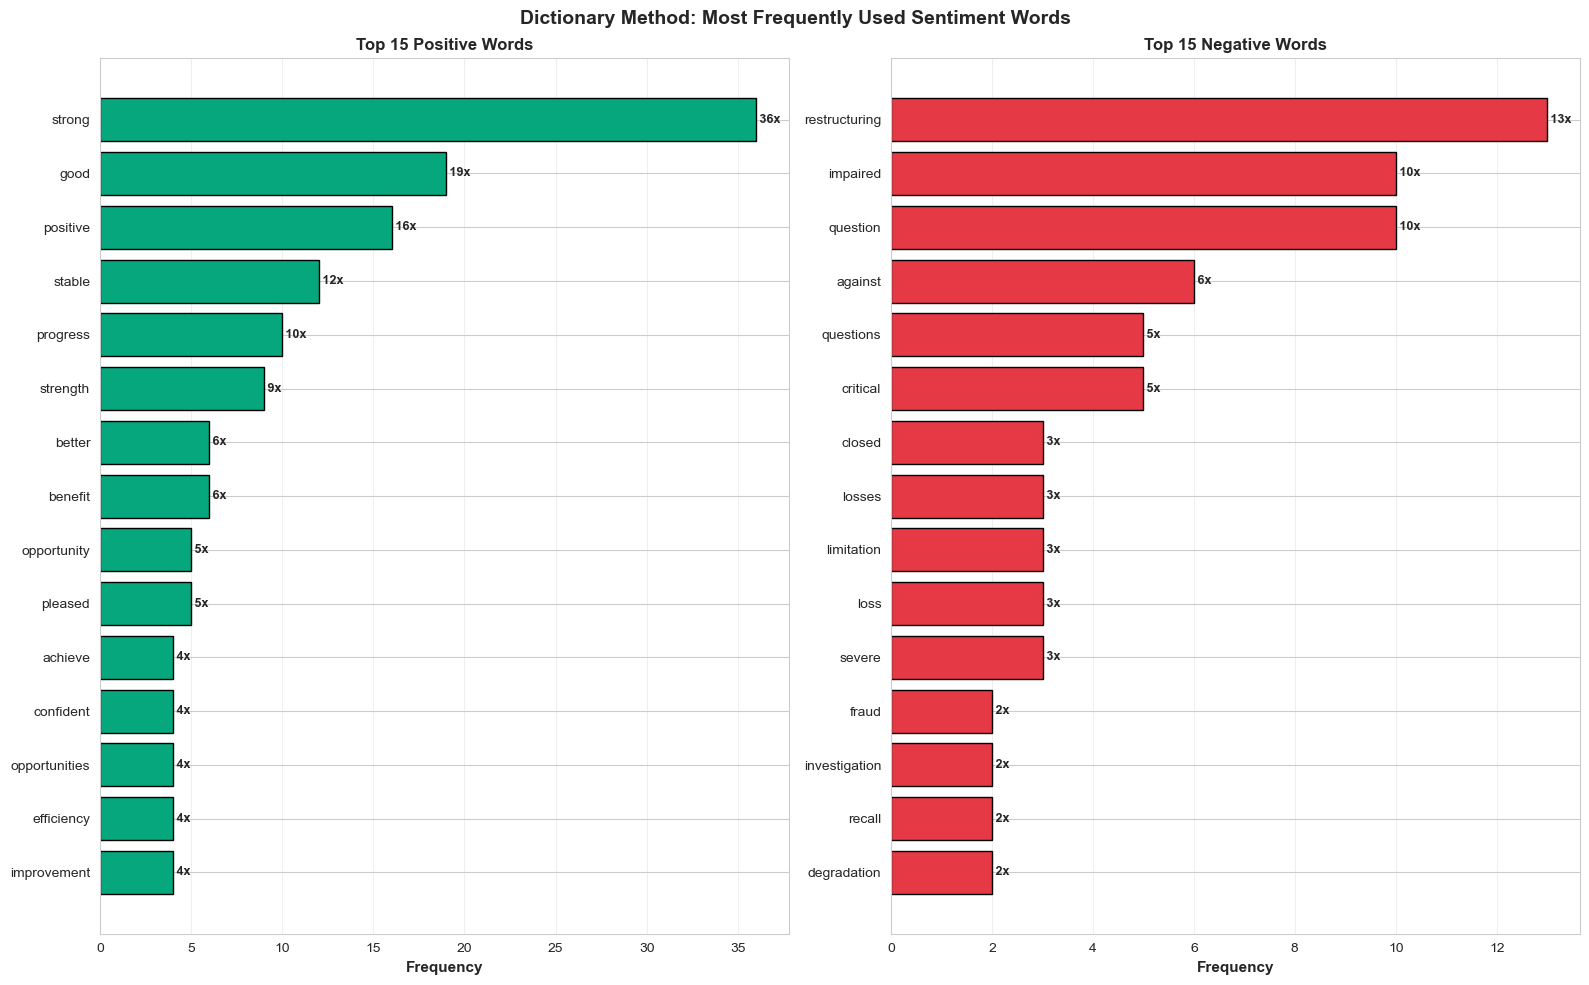

In [40]:
# Create side-by-side bar charts
fig, (left_panel, right_panel) = plt.subplots(1, 2, figsize=(16, 10))

top_n = 15

# LEFT: Positive words
pos_data = top_positive_df.head(top_n)
left_panel.barh(range(len(pos_data)), pos_data['Frequency'], 
                color='#06A77D', edgecolor='black', linewidth=1)
left_panel.set_yticks(range(len(pos_data)))
left_panel.set_yticklabels(pos_data['Word'])
left_panel.set_xlabel('Frequency', fontsize=11, fontweight='bold')
left_panel.set_title(f'Top {top_n} Positive Words', fontsize=12, fontweight='bold')
left_panel.invert_yaxis()
left_panel.grid(True, alpha=0.3, axis='x')

for i, freq in enumerate(pos_data['Frequency']):
    left_panel.text(freq, i, f' {freq}x', va='center', fontsize=9, fontweight='bold')

# RIGHT: Negative words
neg_data = top_negative_df.head(top_n)
right_panel.barh(range(len(neg_data)), neg_data['Frequency'], 
                 color='#E63946', edgecolor='black', linewidth=1)
right_panel.set_yticks(range(len(neg_data)))
right_panel.set_yticklabels(neg_data['Word'])
right_panel.set_xlabel('Frequency', fontsize=11, fontweight='bold')
right_panel.set_title(f'Top {top_n} Negative Words', fontsize=12, fontweight='bold')
right_panel.invert_yaxis()
right_panel.grid(True, alpha=0.3, axis='x')

for i, freq in enumerate(neg_data['Frequency']):
    right_panel.text(freq, i, f' {freq}x', va='center', fontsize=9, fontweight='bold')

plt.suptitle('Dictionary Method: Most Frequently Used Sentiment Words', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Visualization 2: Dictionary Method - Overall Sentiment

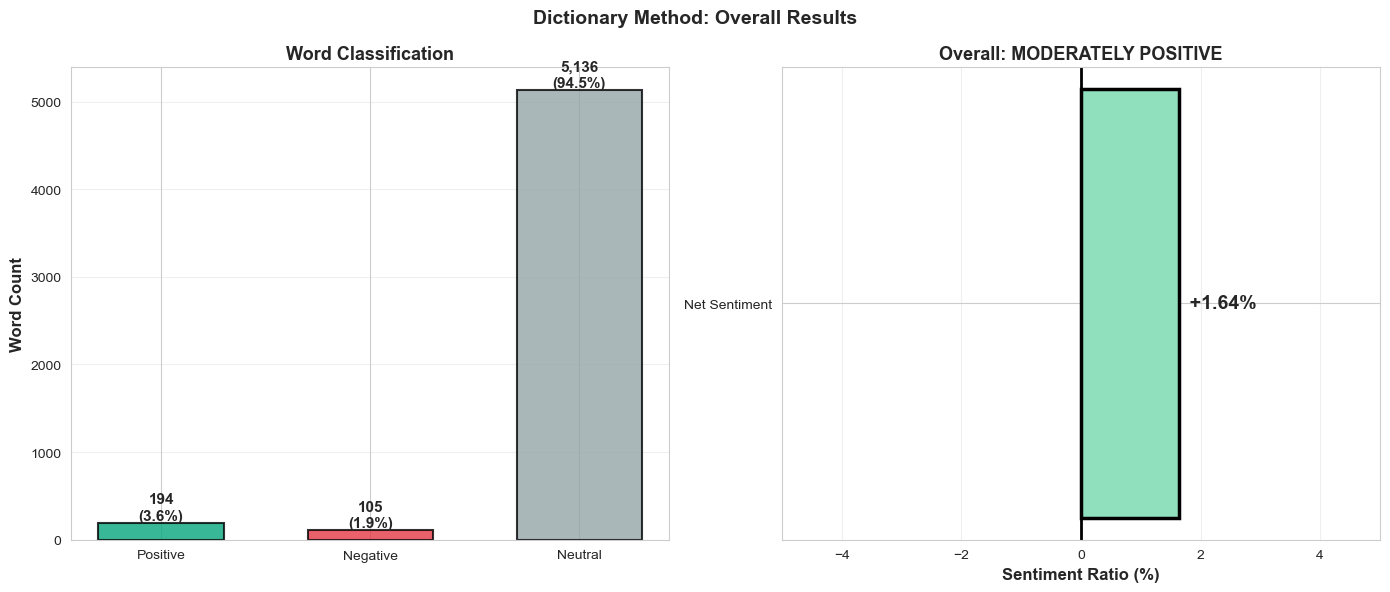

In [46]:
# Create overall sentiment visualization
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 6))

# LEFT: Word composition
neutral_words = total_words - total_positive - total_negative
components = ['Positive', 'Negative', 'Neutral']
counts = [total_positive, total_negative, neutral_words]
colors = ['#06A77D', '#E63946', '#95A5A6']

bars = left_ax.bar(components, counts, color=colors, edgecolor='black', 
                   linewidth=1.5, width=0.6, alpha=0.8)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    pct = count / total_words * 100
    left_ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')

left_ax.set_ylabel('Word Count', fontsize=12, fontweight='bold')
left_ax.set_title('Word Classification', fontsize=13, fontweight='bold')
left_ax.grid(True, alpha=0.3, axis='y')

# RIGHT: Net sentiment gauge
if overall_sentiment_ratio > 2:
    color = '#06A77D'
    label = 'STRONGLY POSITIVE'
elif overall_sentiment_ratio > 0.5:
    color = '#90E0BD'
    label = 'MODERATELY POSITIVE'
elif overall_sentiment_ratio > -0.5:
    color = '#FFA500'
    label = 'NEUTRAL'
elif overall_sentiment_ratio > -2:
    color = '#F4A6A3'
    label = 'MODERATELY NEGATIVE'
else:
    color = '#E63946'
    label = 'STRONGLY NEGATIVE'

right_ax.barh(['Net Sentiment'], [overall_sentiment_ratio], 
              color=color, edgecolor='black', linewidth=2.5, height=0.5)
right_ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
right_ax.text(overall_sentiment_ratio, 0, f'  {overall_sentiment_ratio:+.2f}%',
             va='center', ha='left' if overall_sentiment_ratio > 0 else 'right',
             fontsize=14, fontweight='bold')

right_ax.set_xlabel('Sentiment Ratio (%)', fontsize=12, fontweight='bold')
right_ax.set_title(f'Overall: {label}', fontsize=13, fontweight='bold')
right_ax.set_xlim(-5, 5)
right_ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('Dictionary Method: Overall Results', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Visualization 3: Dictionary Method - Sentiment by Page

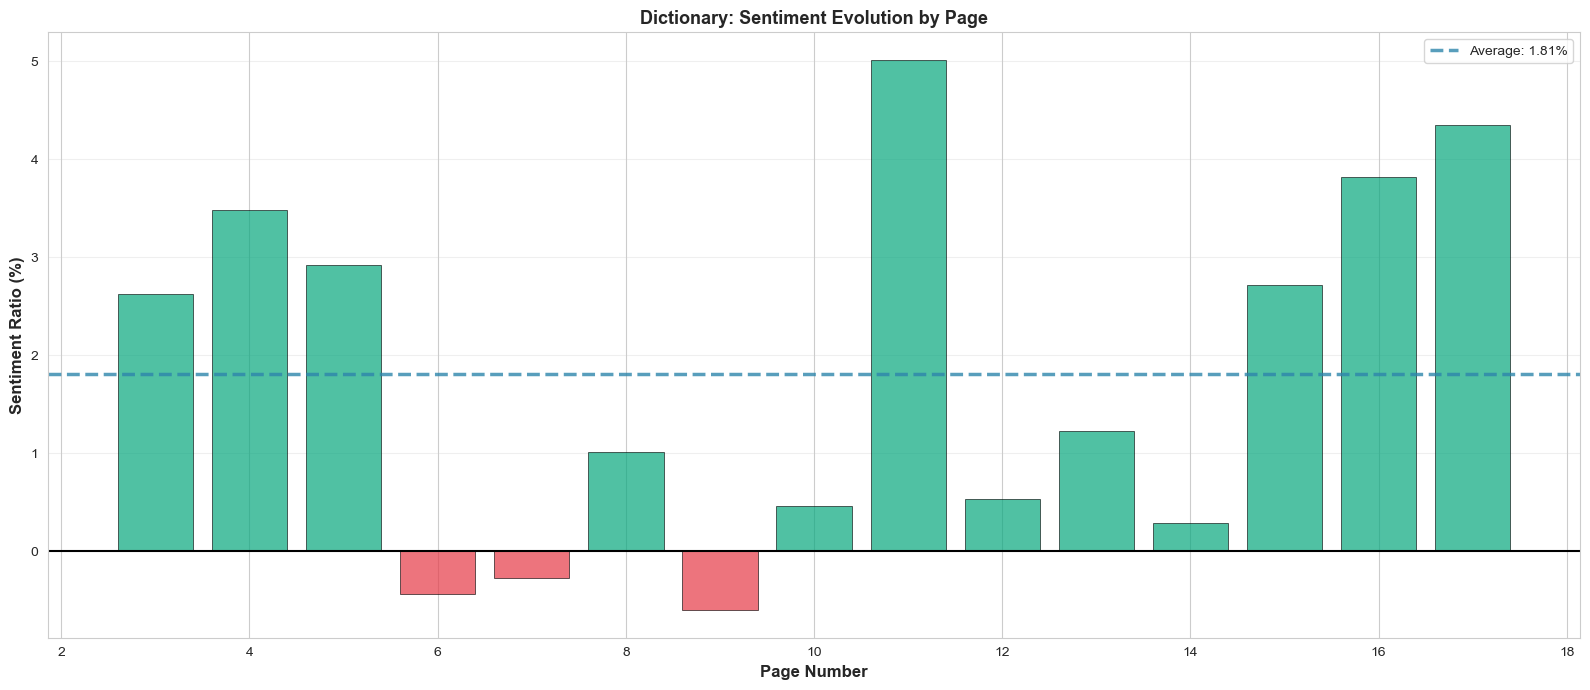

In [47]:
# Create page evolution chart
fig, ax = plt.subplots(figsize=(16, 7))

page_numbers = substantive_content['page_number']
sentiment_ratios = substantive_content['sentiment_ratio']
colors = ['#06A77D' if s > 0 else '#E63946' for s in sentiment_ratios]

ax.bar(page_numbers, sentiment_ratios, color=colors, alpha=0.7, 
       edgecolor='black', linewidth=0.6)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax.axhline(y=sentiment_ratios.mean(), color='#2E86AB', linestyle='--', 
           linewidth=2.5, label=f'Average: {sentiment_ratios.mean():.2f}%', alpha=0.8)

ax.set_xlabel('Page Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Sentiment Ratio (%)', fontsize=12, fontweight='bold')
ax.set_title('Dictionary: Sentiment Evolution by Page', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Part 2: FinBERT Analysis

### What FinBERT Does Differently:

- FinBERT analyzes sentences and paragraphs, not individual words.
- It was trained on 4,271 financial documents where human experts labeled entire sentences as positive, negative, or neutral. The model learned patterns in how financial language expresses sentiment.


For each page of text, FinBERT:
1. Reads the entire page as a coherent piece (up to 512 words)
2. Outputs three probability scores that sum to 100%:
   - **Positive Probability** (0-100%): How positive the page sounds
   - **Negative Probability** (0-100%): How negative the page sounds
   - **Neutral Probability** (0-100%): How neutral/balanced the page sounds
3. Assigns a label based on highest probability
4. We then calculate net Score = Positive Probability - Negative Probability (ranges from -1 to +1)

### Example:

Sentence: "Despite regulatory challenges, we delivered strong performance."

- Dictionary sees: "challenges" (-1) + "strong" (+1) + "performance" (+1) = +1 (slightly positive)
- FinBERT sees: The word "despite" signals overcoming obstacles → 75% positive, 10% negative, 15% neutral
- Net Score: +0.65 (strongly positive)

### What FinBERT improves:

1. Tested Accuracy: 86% accuracy on financial sentiment (vs 71% for generic models)
2. Context Understanding: Handles "not bad" (positive), "without risk" (positive), "despite challenges" (can be positive)
3. Financial Training: Trained specifically on financial text
4. Probability Scores: Shows confidence scores

In [48]:
# Load FinBERT model and tokenizer
print("Loading FinBERT model...")
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert") #splits text into pieces (tokens) and converts each token into an ID number 
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert") #takes the token ID and output sentiment probabilities
print("FinBERT loaded successfully!")

Loading FinBERT model...
FinBERT loaded successfully!


## Step 13: Apply FinBERT to Each Page

For transparency, we show exactly how FinBERT scores each page.

In [49]:
# Define function to analyze text with FinBERT
def analyze_with_finbert(text, tokenizer, model):
    # converts text into tokens
    tokenized_inputs = tokenizer(
        text, 
        return_tensors="pt",  # Return PyTorch tensors
        truncation=True,       # Cut text if longer than 512 words
        max_length=512,        # Maximum length FinBERT can process
        padding=True           # Pad shorter texts to same length
    )
    
    # Run the text through FinBERT model
    with torch.no_grad():  #FinBERT is already trained, we are not training the model, so we can skip gradient which is a method of reducing error.
        model_outputs = model(**tokenized_inputs)
        
        # Convert raw scores to probabilities (softmax ensures they sum to 1)
        probabilities = torch.nn.functional.softmax(model_outputs.logits, dim=-1)
    
    # Extract the three probability scores
    # FinBERT outputs: [positive, negative, neutral]
    positive_prob = probabilities[0][0].item()
    negative_prob = probabilities[0][1].item()
    neutral_prob = probabilities[0][2].item()
    
    # Determine overall label (whichever has highest probability)
    if positive_prob > negative_prob and positive_prob > neutral_prob:
        label = 'positive'
    elif negative_prob > positive_prob and negative_prob > neutral_prob:
        label = 'negative'
    else:
        label = 'neutral'
    
    # Calculate net score (ranges from -1 to +1)
    net_score = positive_prob - negative_prob
    
    return positive_prob, negative_prob, neutral_prob, label, net_score

print(f"Applying FinBERT to {len(substantive_content)} pages of substantive content...")
print(f"Starting from page {start_page} (same as Dictionary method)")
print()

# Apply FinBERT to each page and store detailed results
finbert_results = []

for idx, row in substantive_content.iterrows():
    # Get the raw text for this page (FinBERT works best with original text)
    page_text = row['raw_text']
    page_num = row['page_number']
    
    # Analyze this page with FinBERT
    pos_prob, neg_prob, neu_prob, label, net = analyze_with_finbert(
        page_text, finbert_tokenizer, finbert_model
    )
    
    # Store results
    finbert_results.append({
        'page_number': page_num,
        'finbert_positive_prob': pos_prob,
        'finbert_negative_prob': neg_prob,
        'finbert_neutral_prob': neu_prob,
        'finbert_label': label,
        'finbert_net_score': net
    })
    
    # Show progress every 3 pages
    processed = idx - substantive_content.index[0] + 1
    if processed % 3 == 0:
        print(f"  Processed {processed}/{len(substantive_content)} pages...")

# Convert to DataFrame and merge with main data
finbert_df = pd.DataFrame(finbert_results)
substantive_content = substantive_content.merge(finbert_df, on='page_number', how='left')

print(f"\nFinBERT analysis complete!")

Applying FinBERT to 15 pages of substantive content...
Starting from page 3 (same as Dictionary method)

  Processed 3/15 pages...
  Processed 6/15 pages...
  Processed 9/15 pages...
  Processed 12/15 pages...
  Processed 15/15 pages...

FinBERT analysis complete!


## Understanding FinBERT's Score Calculation

### Example Page Scoring:

**Page 5:**
- Positive: 80%
- Negative: 5%
- Neutral: 15%
- **Net Score = 0.80 - 0.05 = +0.75** (strongly positive)

**Page 10:**
- Positive: 30%
- Negative: 50%
- Neutral: 20%
- **Net Score = 0.30 - 0.50 = -0.20** (moderately negative)

### How the Overall Score is Calculated:

The **Overall Net Score** is simply the **AVERAGE of all page-level net scores**:

```
Overall Net Score = (Page 1 Net Score + Page 2 Net Score + ... + Page N Net Score) / N
```

### Key Difference from Dictionary Method:

**Dictionary:** Counts words → (positive words - negative words) / total words
- Example: (50 positive - 30 negative) / 1000 words = +2.0%

**FinBERT:** Averages probability scores → average of page net scores
- Example: Average of [+0.75, +0.50, -0.20] = +0.35

Both tell you sentiment direction, but FinBERT's scale (-1 to +1) is normalized, while Dictionary's is percentage-based.

## Step 14: FinBERT Overall Results

Now let's see the actual scores from our analysis:

In [70]:
# Calculate overall FinBERT statistics
avg_positive_prob = substantive_content['finbert_positive_prob'].mean()
avg_negative_prob = substantive_content['finbert_negative_prob'].mean()
avg_neutral_prob = substantive_content['finbert_neutral_prob'].mean()
avg_net_score = substantive_content['finbert_net_score'].mean()

# Count pages by label
label_counts = substantive_content['finbert_label'].value_counts()

print(f"Overall Net Score = Average of all page net scores = {avg_net_score:+.3f}\n")
print(f"Average Probability Scores Across All Pages:\n")

print(f"  Positive: {avg_positive_prob:.1%} (on average, FinBERT sees {avg_positive_prob:.1%} positive sentiment per page)")
print(f"  Negative: {avg_negative_prob:.1%} (on average, FinBERT sees {avg_negative_prob:.1%} negative sentiment per page)")
print(f"  Neutral:  {avg_neutral_prob:.1%} (on average, FinBERT sees {avg_neutral_prob:.1%} neutral sentiment per page)\n")

print(f"Overall Net Sentiment Score: {avg_net_score:+.3f}")
print(f"  Calculation: {avg_positive_prob:.3f} - {avg_negative_prob:.3f} = {avg_net_score:+.3f}")
print()
print("Page-by-Page Classification:")
for sentiment, count in label_counts.items():
    pct = count / len(substantive_content) * 100
    print(f"  {sentiment.capitalize()}: {count} pages ({pct:.1f}%)")
print()
print(f"Interpretation: FinBERT found {label_counts.get('positive', 0)} positive pages, ")
print(f"{label_counts.get('neutral', 0)} neutral pages, and {label_counts.get('negative', 0)} negative pages.")

Overall Net Score = Average of all page net scores = +0.463

Average Probability Scores Across All Pages:

  Positive: 56.3% (on average, FinBERT sees 56.3% positive sentiment per page)
  Negative: 9.9% (on average, FinBERT sees 9.9% negative sentiment per page)
  Neutral:  33.8% (on average, FinBERT sees 33.8% neutral sentiment per page)

Overall Net Sentiment Score: +0.463
  Calculation: 0.563 - 0.099 = +0.463

Page-by-Page Classification:
  Positive: 7 pages (46.7%)
  Neutral: 6 pages (40.0%)
  Negative: 2 pages (13.3%)

Interpretation: FinBERT found 7 positive pages, 
6 neutral pages, and 2 negative pages.


## Step 15: Show FinBERT Sentence-Level Examples

To build confidence in FinBERT, we analyzed individual sentences from each page type and show which sentences most influenced the overall classification.

In [73]:
# Define function to analyze individual sentences with FinBERT
def analyze_sentence_with_finbert(sentence, tokenizer, model):
    # Clean the sentence first
    sentence = sentence.strip()
    
    # Skip very short sentences
    if len(sentence) < 20:
        return None
    
    # Skip sentences that are boilerplate
    # Page references
    if re.search(r'Page\s+\d+\s+of\s+\d+', sentence, re.IGNORECASE):
        return None
    
    # Earnings call transcript headers
    if 'Earnings Call Transcript' in sentence or 'Q4 2025' in sentence:
        return None
    
    # Section headers (short, mostly caps or title case with few words)
    if len(sentence) < 60 and sentence.count(' ') < 5:
        return None
    
    # Speaker headers with dashes
    if sentence.count(' - ') >= 2 or sentence.count('–') >= 2:
        if len(sentence) < 100:
            return None
    
    try:
        # Tokenize and analyze the sentence
        tokenized = tokenizer(sentence, return_tensors="pt", truncation=True, 
                             max_length=512, padding=True)
        with torch.no_grad():
            outputs = model(**tokenized)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        pos_prob = probs[0][0].item()
        neg_prob = probs[0][1].item()
        neu_prob = probs[0][2].item()
        net_score = pos_prob - neg_prob
        
        return {
            'sentence': sentence[:300],  # Limit length for display
            'positive_prob': pos_prob,
            'negative_prob': neg_prob,
            'neutral_prob': neu_prob,
            'net_score': net_score
        }
    except:
        return None

print("FINBERT SENTENCE-LEVEL ANALYSIS EXAMPLES\n")
print("Analyzing individual sentences to show what drives FinBERT's classifications:")

# Get pages with different sentiment classifications
most_positive_page = substantive_content.nlargest(1, 'finbert_net_score').iloc[0]
most_negative_page = substantive_content.nsmallest(1, 'finbert_net_score').iloc[0]
most_neutral_page = substantive_content.iloc[(substantive_content['finbert_net_score'].abs()).argmin()]

example_pages = [
    (most_positive_page, "MOST POSITIVE", "positive"),
    (most_negative_page, "MOST NEGATIVE", "negative"),
    (most_neutral_page, "MOST NEUTRAL", "neutral")
]

for page, description, target_sentiment in example_pages:
    print(f"{description} PAGE (Page {int(page['page_number'])})\n")

    
    # Split page into sentences
    sentences = page['raw_text'].split('.')
    
    # Analyze each sentence individually
    sentence_results = []
    for sentence in sentences:
        result = analyze_sentence_with_finbert(sentence, finbert_tokenizer, finbert_model)
        if result:
            sentence_results.append(result)
        # Limit to first 15 sentences to avoid too much processing
        if len(sentence_results) >= 15:
            break
    
    # Find the sentences with strongest sentiment matching page classification
    if target_sentiment == "positive":
        # Get sentences with highest positive scores
        top_sentences = sorted(sentence_results, key=lambda x: x['net_score'], reverse=True)[:2]
        print("Showing the 2 sentences with STRONGEST POSITIVE sentiment:")
    elif target_sentiment == "negative":
        # Get sentences with highest negative scores
        top_sentences = sorted(sentence_results, key=lambda x: x['net_score'])[:2]
        print("Showing the 2 sentences with STRONGEST NEGATIVE sentiment:")
    else:
        # Get sentences closest to neutral
        top_sentences = sorted(sentence_results, key=lambda x: abs(x['net_score']))[:2]
        print("Showing the 2 sentences with MOST NEUTRAL sentiment:")
    
    print()
    
    # Display the top sentences
    for idx, sent_result in enumerate(top_sentences, 1):
        print(f"Sentence {idx}:")
        print(f'  Text: "{sent_result["sentence"]}"')
        print()
        print(f"  FinBERT's Analysis:")
        print(f"    Positive Probability: {sent_result['positive_prob']:.1%}")
        print(f"    Negative Probability: {sent_result['negative_prob']:.1%}")
        print(f"    Neutral Probability:  {sent_result['neutral_prob']:.1%}")
        print(f"    Net Score: {sent_result['net_score']:+.3f}")
        
        # Determine label
        if sent_result['positive_prob'] > sent_result['negative_prob'] and sent_result['positive_prob'] > sent_result['neutral_prob']:
            label = 'POSITIVE'
        elif sent_result['negative_prob'] > sent_result['positive_prob'] and sent_result['negative_prob'] > sent_result['neutral_prob']:
            label = 'NEGATIVE'
        else:
            label = 'NEUTRAL'
        
        max_prob = max(sent_result['positive_prob'], sent_result['negative_prob'], sent_result['neutral_prob'])
        print(f"    Classification: {label}")
        print(f"    Confidence: {max_prob:.0%}")
        print()
    
    # Show page-level summary
    print(f"Overall Page Classification:")
    print(f"  Positive Probability: {page['finbert_positive_prob']:.1%}")
    print(f"  Negative Probability: {page['finbert_negative_prob']:.1%}")
    print(f"  Neutral Probability:  {page['finbert_neutral_prob']:.1%}")
    print(f"  Net Score: {page['finbert_net_score']:+.3f}")
    print(f"  Classification: {page['finbert_label'].upper()}")
    print()
    print(f"Interpretation: The sentences shown above are the primary drivers of this page's {description.lower()} classification.")
    print()
    print()


print("KEY INSIGHTS:\n")


print("Showing the most influential sentences helps explain FinBERT's reasoning")

FINBERT SENTENCE-LEVEL ANALYSIS EXAMPLES

Analyzing individual sentences to show what drives FinBERT's classifications:
MOST POSITIVE PAGE (Page 8)

Showing the 2 sentences with STRONGEST POSITIVE sentiment:

Sentence 1:
  Text: "Our key message for the quarter is that credit results for the Bank are strong"

  FinBERT's Analysis:
    Positive Probability: 95.4%
    Negative Probability: 1.6%
    Neutral Probability:  3.1%
    Net Score: +0.938
    Classification: POSITIVE
    Confidence: 95%

Sentence 2:
  Text: "And – reflecting our commitment to return value to shareholders – we bought back over $6 billion in shares this year, helping drive EPS up 7% year-over-year"

  FinBERT's Analysis:
    Positive Probability: 95.0%
    Negative Probability: 1.6%
    Neutral Probability:  3.4%
    Net Score: +0.934
    Classification: POSITIVE
    Confidence: 95%

Overall Page Classification:
  Positive Probability: 95.0%
  Negative Probability: 2.5%
  Neutral Probability:  2.4%
  Net Score: +0.

## Visualization 4: FinBERT - Overall Sentiment Distribution

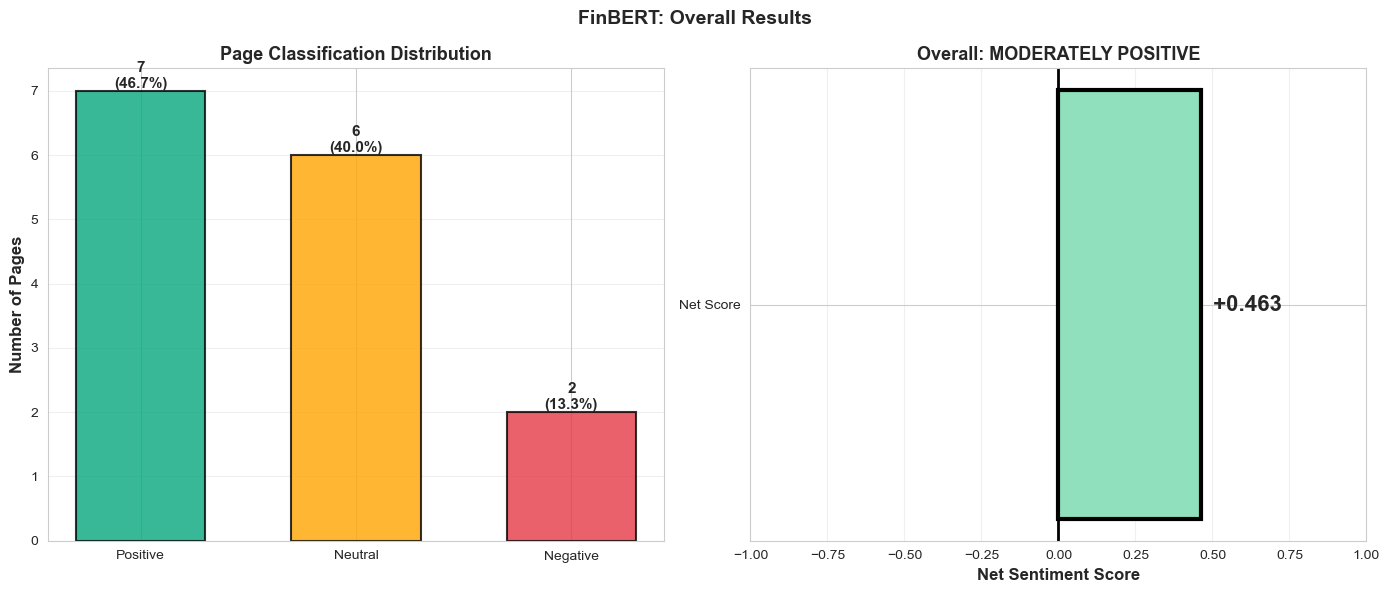


FinBERT Overall Assessment: MODERATELY POSITIVE
Confidence: Average positive probability of 56.3% vs negative 9.9%


In [77]:
# Create comprehensive FinBERT visualization
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 6))

# LEFT: Page classification distribution
labels = ['Positive', 'Neutral', 'Negative']
counts = [
    label_counts.get('positive', 0),
    label_counts.get('neutral', 0),
    label_counts.get('negative', 0)
]
colors = ['#06A77D', '#FFA500', '#E63946']

bars = left_ax.bar(labels, counts, color=colors, edgecolor='black', 
                   linewidth=1.5, width=0.6, alpha=0.8)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    pct = count / len(substantive_content) * 100
    left_ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\n({pct:.1f}%)', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')

left_ax.set_ylabel('Number of Pages', fontsize=12, fontweight='bold')
left_ax.set_title('Page Classification Distribution', fontsize=13, fontweight='bold')
left_ax.grid(True, alpha=0.3, axis='y')

# RIGHT: Net score gauge
if avg_net_score > 0.6:
    color = '#06A77D'
    label_text = 'STRONGLY POSITIVE'
elif avg_net_score > 0.3:
    color = '#90E0BD'
    label_text = 'MODERATELY POSITIVE'
elif avg_net_score > -0.1:
    color = '#FFA500'
    label_text = 'NEUTRAL'
elif avg_net_score > -0.3:
    color = '#F4A6A3'
    label_text = 'MODERATELY NEGATIVE'
else:
    color = '#E63946'
    label_text = 'STRONGLY NEGATIVE'

right_ax.barh(['Net Score'], [avg_net_score], 
              color=color, edgecolor='black', linewidth=3, height=0.5)
right_ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
right_ax.text(avg_net_score, 0, f'  {avg_net_score:+.3f}',
             va='center', ha='left' if avg_net_score > 0 else 'right',
             fontsize=16, fontweight='bold')

right_ax.set_xlabel('Net Sentiment Score', fontsize=12, fontweight='bold')
right_ax.set_title(f'Overall: {label_text}', fontsize=13, fontweight='bold')
right_ax.set_xlim(-1, 1)
right_ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('FinBERT: Overall Results', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"\nFinBERT Overall Assessment: {label_text}")
print(f"Confidence: Average positive probability of {avg_positive_prob:.1%} vs negative {avg_negative_prob:.1%}")

## Visualization 5: FinBERT - Sentiment by Page

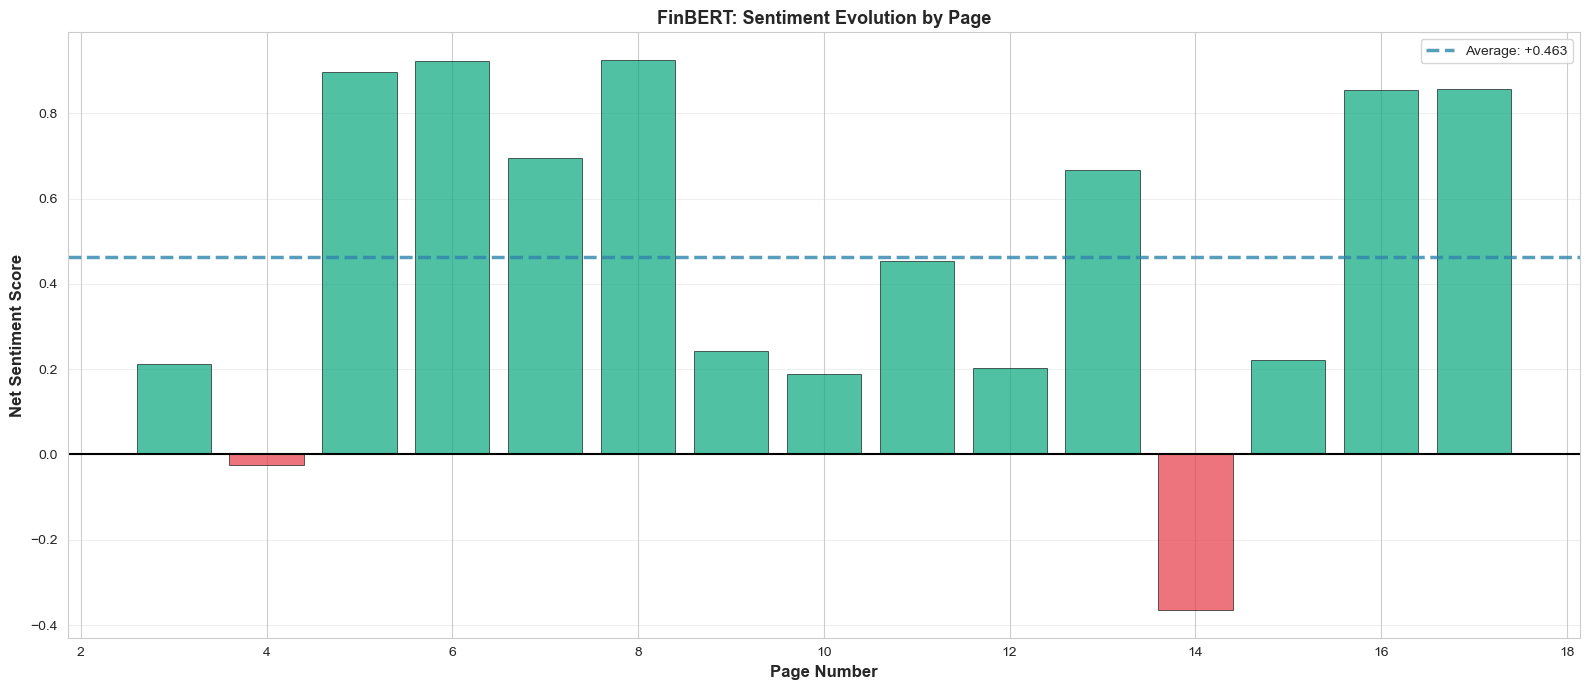

In [75]:
# Create page-by-page chart
fig, ax = plt.subplots(figsize=(16, 7))

page_nums = substantive_content['page_number']
net_scores = substantive_content['finbert_net_score']
colors = ['#06A77D' if s > 0 else '#E63946' for s in net_scores]

ax.bar(page_nums, net_scores, color=colors, alpha=0.7, 
       edgecolor='black', linewidth=0.6)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax.axhline(y=avg_net_score, color='#2E86AB', linestyle='--', 
           linewidth=2.5, label=f'Average: {avg_net_score:+.3f}', alpha=0.8)

ax.set_xlabel('Page Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Net Sentiment Score', fontsize=12, fontweight='bold')
ax.set_title('FinBERT: Sentiment Evolution by Page', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Part 3: Method Comparison

Now we compare Dictionary and FinBERT to understand when and why they agree or disagree.

## Step 16: Calculate Method Comparison

In [76]:
# Normalize both scores to comparable scale (-1 to +1)
substantive_content['dictionary_normalized'] = substantive_content['sentiment_ratio'] / 3
substantive_content['finbert_normalized'] = substantive_content['finbert_net_score']

# Calculate correlation
correlation = substantive_content[[
    'dictionary_normalized', 'finbert_normalized'
]].corr().iloc[0, 1]

# Calculate directional agreement
substantive_content['methods_agree'] = (
    ((substantive_content['dictionary_normalized'] > 0) & (substantive_content['finbert_normalized'] > 0)) |
    ((substantive_content['dictionary_normalized'] < 0) & (substantive_content['finbert_normalized'] < 0))
)

agreement_rate = substantive_content['methods_agree'].mean()

print("="*80)
print("METHOD COMPARISON SUMMARY")
print("="*80)
print()
print(f"Correlation: {correlation:.3f}")
print(f"Directional Agreement: {agreement_rate:.1%}")
print()
if correlation > 0.7:
    print("Interpretation: STRONG AGREEMENT - Both methods capture similar patterns")
elif correlation > 0.4:
    print("Interpretation: MODERATE AGREEMENT - Methods measure related but distinct aspects")
else:
    print("Interpretation: LOW AGREEMENT - Methods capture different dimensions")

METHOD COMPARISON SUMMARY

Correlation: 0.142
Directional Agreement: 66.7%

Interpretation: LOW AGREEMENT - Methods capture different dimensions


## Step 17: Analyze Specific Disagreement Cases

We identify specific sentences where methods disagree to understand WHY context matters.

In [66]:
# Calculate difference between methods
substantive_content['method_difference'] = abs(
    substantive_content['dictionary_normalized'] - substantive_content['finbert_normalized']
)

# Get pages with largest disagreements
disagreement_pages = substantive_content.nlargest(5, 'method_difference')

# Extract example sentences showing disagreements
disagreement_examples = []

for _, page in disagreement_pages.iterrows():
    sentences = page['raw_text'].split('.')
    
    for sentence in sentences[:10]:
        sentence = sentence.strip()
        if len(sentence) < 30 or len(sentence) > 300:
            continue
        
        # Count sentiment words in sentence
        words = sentence.lower().split()
        pos_words = [w for w in words if w in positive_words_set]
        neg_words = [w for w in words if w in negative_words_set]
        
        # Look for mixed sentiment
        if len(pos_words) > 0 and len(neg_words) > 0:
            # Determine dictionary classification
            if len(pos_words) > len(neg_words):
                dict_class = "Positive"
            elif len(neg_words) > len(pos_words):
                dict_class = "Negative"
            else:
                dict_class = "Neutral"
            
            # Determine FinBERT classification
            if page['finbert_net_score'] > 0.2:
                finbert_class = "Positive"
            elif page['finbert_net_score'] < -0.2:
                finbert_class = "Negative"
            else:
                finbert_class = "Neutral"
            
            # Identify key words
            key_words = []
            for w in pos_words[:2]:
                key_words.append(f"{w} (pos)")
            for w in neg_words[:2]:
                key_words.append(f"{w} (neg)")
            
            # Determine action
            if dict_class != finbert_class:
                action = "REVIEW: Methods disagree - context may override word counts"
            else:
                action = "ALIGNED: Both methods agree despite mixed signals"
            
            disagreement_examples.append({
                'Key Words': ', '.join(key_words),
                'Sentence': sentence[:150] + "..." if len(sentence) > 150 else sentence,
                'Dictionary': dict_class,
                'FinBERT': finbert_class,
                'Action': action
            })
            
            if len(disagreement_examples) >= 10:
                break
    
    if len(disagreement_examples) >= 10:
        break

disagreement_df = pd.DataFrame(disagreement_examples)
print(f"Found {len(disagreement_df)} example sentences showing method differences")

Found 3 example sentences showing method differences


## Step 18: Disagreement Analysis Table

In [67]:
# Display detailed disagreement table
print("="*120)
print("METHOD DISAGREEMENT ANALYSIS: When and Why Context Matters")
print("="*120)
print()

for idx, row in disagreement_df.iterrows():
    print(f"\nExample {idx + 1}:")
    print("-" * 120)
    print(f"Key Words Found: {row['Key Words']}")
    print(f"Sentence: {row['Sentence']}")
    print()
    print(f"Dictionary Classification: {row['Dictionary']} (counts individual words)")
    print(f"FinBERT Classification: {row['FinBERT']} (understands full context)")
    print()
    print(f"Action: {row['Action']}")
    print("-" * 120)

# Export table
disagreement_df.to_csv('method_disagreement_analysis.csv', index=False)
print("\n\nTable exported to: method_disagreement_analysis.csv")

# Summary
print("\n" + "="*120)
print("KEY INSIGHTS")
print("="*120)
print()
print(f"Overall Correlation: {correlation:.3f}")
print(f"Agreement Rate: {agreement_rate:.1%}")
print()
print("When methods disagree, it's usually because:")
print("  1. Negation: 'not bad', 'without concerns', 'despite challenges'")
print("  2. Qualification: 'strong but cautious', 'positive despite headwinds'")
print("  3. Complex tone: 'concerned yet optimistic', 'challenged but resilient'")
print()
print("BUSINESS RECOMMENDATIONS:")
print(f"  • Dictionary Score: {overall_sentiment_ratio:+.2f}% - Use for compliance and transparency")
print(f"  • FinBERT Score: {avg_net_score:+.3f} - Use for investment decisions")
print(f"  • Correlation: {correlation:.2f} - {'High trust in both' if correlation > 0.7 else 'Context matters' if correlation > 0.4 else 'Deep analysis needed'}")
print(f"  • Review {len(disagreement_df)} disagreement cases for nuanced understanding")

METHOD DISAGREEMENT ANALYSIS: When and Why Context Matters


Example 1:
------------------------------------------------------------------------------------------------------------------------
Key Words Found: stronger (pos), challenging (neg)
Sentence: This year, we delivered 5% earnings growth – much stronger performance than we anticipated at this time last year, when we expected it would be challe...

Dictionary Classification: Neutral (counts individual words)
FinBERT Classification: Neutral (understands full context)

Action: ALIGNED: Both methods agree despite mixed signals
------------------------------------------------------------------------------------------------------------------------

Example 2:
------------------------------------------------------------------------------------------------------------------------
Key Words Found: progress (pos), against (neg)
Sentence: We made meaningful progress against our objectives this quarter

Dictionary Classification: Neutral (

## Visualization 6: Final Comparison Dashboard

Keeping only the two most informative comparison charts.

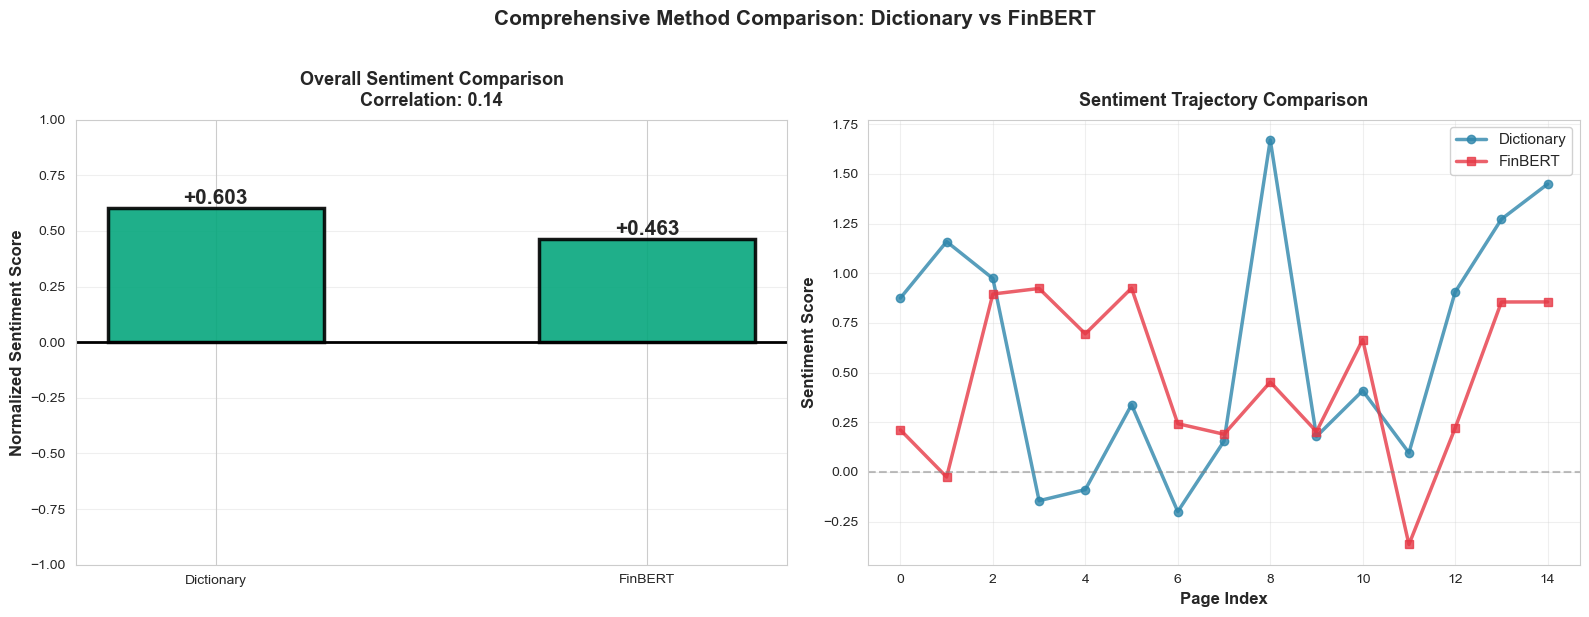


KEY TAKEAWAYS FROM VISUALIZATION:
1. Dictionary: +0.603 | FinBERT: +0.463
2. Correlation: 0.14 - Low agreement
3. Trajectory shows how sentiment evolves through the call
4. Use both methods for complete picture


In [68]:
# Create focused comparison with just the two key visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# PANEL 1: Overall score comparison
methods = ['Dictionary', 'FinBERT']
scores = [
    substantive_content['dictionary_normalized'].mean(),
    substantive_content['finbert_normalized'].mean()
]
colors = ['#06A77D' if s > 0 else '#E63946' for s in scores]

bars = ax1.bar(methods, scores, color=colors, edgecolor='black', 
               linewidth=2.5, width=0.5, alpha=0.9)
ax1.axhline(y=0, color='black', linewidth=2)

for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:+.3f}', ha='center', 
            va='bottom' if height > 0 else 'top',
            fontsize=15, fontweight='bold')

ax1.set_ylabel('Normalized Sentiment Score', fontsize=12, fontweight='bold')
ax1.set_title(f'Overall Sentiment Comparison\nCorrelation: {correlation:.2f}', 
             fontsize=13, fontweight='bold', pad=10)
ax1.set_ylim(-1, 1)
ax1.grid(True, alpha=0.3, axis='y')

# PANEL 2: Sentiment trajectory
x = range(len(substantive_content))
ax2.plot(x, substantive_content['dictionary_normalized'], 
         marker='o', linewidth=2.5, markersize=6, 
         label='Dictionary', color='#2E86AB', alpha=0.8)
ax2.plot(x, substantive_content['finbert_normalized'], 
         marker='s', linewidth=2.5, markersize=6, 
         label='FinBERT', color='#E63946', alpha=0.8)
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

ax2.set_xlabel('Page Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sentiment Score', fontsize=12, fontweight='bold')
ax2.set_title('Sentiment Trajectory Comparison', fontsize=13, fontweight='bold', pad=10)
ax2.legend(loc='best', fontsize=11, framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Method Comparison: Dictionary vs FinBERT', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nKEY TAKEAWAYS FROM VISUALIZATION:")
print(f"1. Dictionary: {scores[0]:+.3f} | FinBERT: {scores[1]:+.3f}")
print(f"2. Correlation: {correlation:.2f} - {'Methods strongly agree' if correlation > 0.7 else 'Moderate agreement' if correlation > 0.4 else 'Low agreement'}")
print(f"3. Trajectory shows how sentiment evolves through the call")
print(f"4. Use both methods for complete picture")

## Step 19: Export Complete Results

In [69]:
# Export comprehensive results
export_data = substantive_content[[
    'page_number', 'word_count',
    'positive_count', 'negative_count', 'sentiment_ratio',
    'finbert_positive_prob', 'finbert_negative_prob', 'finbert_neutral_prob',
    'finbert_label', 'finbert_net_score',
    'dictionary_normalized', 'finbert_normalized', 
    'method_difference', 'methods_agree'
]].copy()

export_data.to_csv('earnings_sentiment_complete_analysis.csv', index=False)

print("EXPORT COMPLETE")
print(f"\nMain results: earnings_sentiment_complete_analysis.csv")
print(f"Disagreement examples: method_disagreement_analysis.csv")
print(f"\nTotal pages analyzed: {len(export_data)}")
print(f"Starting from page: {start_page}")
print(f"\nBoth methods analyzed the exact same content for fair comparison.")

EXPORT COMPLETE

Main results: earnings_sentiment_complete_analysis.csv
Disagreement examples: method_disagreement_analysis.csv

Total pages analyzed: 15
Starting from page: 3

Both methods analyzed the exact same content for fair comparison.
